In [3]:
%load_ext autoreload

In [4]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
import colorcet as cc

import torch
import torch.distributions as dist

import umap.umap_ as umap

from hmmlearn import hmm
from model import HMMPoisson
from utils import *

# Import data

In [9]:
df = pd.read_csv("df.csv")
X_pd = df.drop(columns= ["headAngel", "sin_angel", "cos_angel"]) # Droping unimportant columns and head angel
y = df.headAngel

# Vizualization


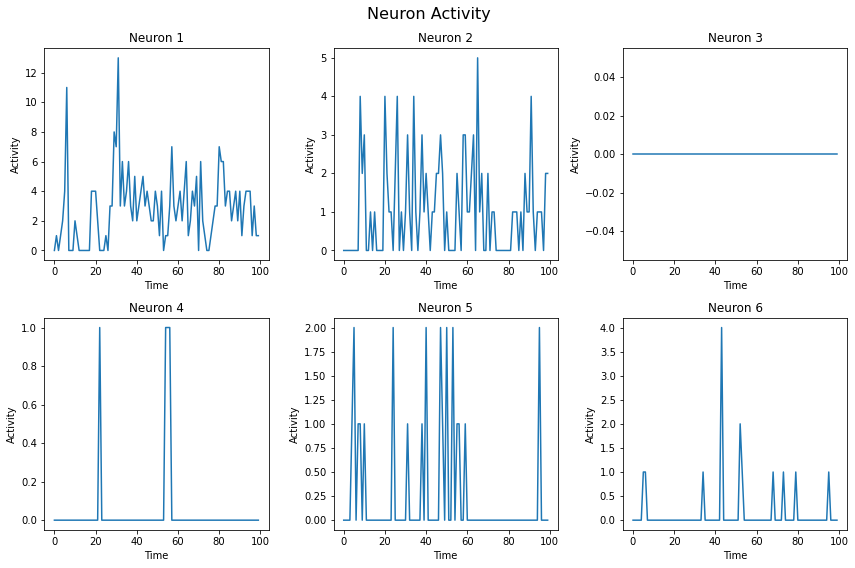

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Neuron Activity", fontsize=16)

t = 100 

for i in range(6):
    row, col = divmod(i,3)
    ax = axes[row, col]
    
    ax.plot(range(t), df[f"cell_{i}"][0:t])
    ax.set_title(f"Neuron {i + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Activity")

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

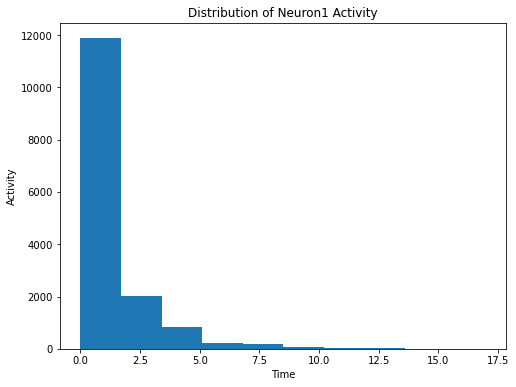

In [11]:
# Create a bar plot for the distribution of Neuron1's activity
plt.figure(figsize=(8, 6))

plt.hist(df["cell_0"])

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Activity')
plt.title('Distribution of Neuron1 Activity')

# Show the plot
plt.show()


# Remove inactive neurons

In [12]:
X_pd = X_pd.loc[:,X_pd.sum(axis=0) > 100]
X_pd.shape

(15243, 59)

# UMAP

In [17]:
df_pure = df[~np.isnan(df["headAngel"])]

X_pure = df_pure.drop(columns= ["headAngel", "sin_angel", "cos_angel"])
y_pure = df_pure.headAngel

X_pure = X_pure.loc[:,X_pure.sum(axis=0) > 100]

In [18]:
X_scaled = StandardScaler().fit_transform(X_pure)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

In [19]:
def map_list_to_segments(values, num_segments=10):
    segment_indices = []

    for value in values:
        if value < 0:
            value = 0
        elif value >= 2 * np.pi:
            value = 2 * np.pi - 1e-6  # To ensure that 2π gets mapped to the last segment.
        
        segment_width = (2 * np.pi) / num_segments
        segment_index = int(value / segment_width)
        segment_indices.append(segment_index)

    return segment_indices

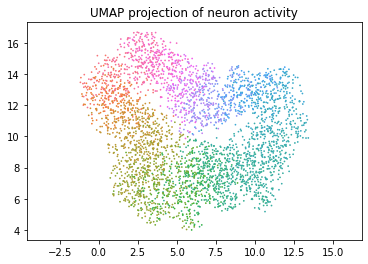

In [20]:
segment_hd = map_list_to_segments(y_pure, len(y_pure))
custom_palette = sns.color_palette("husl", len(segment_hd))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[custom_palette[x] for x in segment_hd], s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

# Modeling

## Own model

In [16]:
n_states = 10
X = torch.tensor(X_pd.values)
n_retraining = 1
m_dimensions = X.shape[1]

model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = HMMPoisson(n_states = n_states, m_dimensions=m_dimensions, verbose=True, max_itterations = 8, tolerance = 500)
    model.fit(X)

    model_list.append(model)
    score_list.append(model.forward(X).item())
    print(f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

1 -2309528.2500  +inf
2 -1079146.1250  +1230382.125
3 -941929.5625  +137216.5625
4 -916919.6250  +25009.9375
5 -905170.1250  +11749.5
6 -900882.8750  +4287.25
7 -900040.7500  +842.125
8 -899669.8750  +370.875
Converged (change in log likelihood within tolerance)


: 

## Sklearn model

In [17]:
n_states = 50
X = X_pd
n_retraining = 5

model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = hmm.PoissonHMM(n_components = n_states, verbose=True, random_state = idx, n_iter=15, tol = 500)
    try:
        model.fit(X)
    except:
        score_list.append(-np.inf)
        continue
    
    model_list.append(model)
    score_list.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}\t\t'
              f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

         1 -3404140.42214370             +nan
         2 -1016730.97026497 +2387409.45187873
         3 -909334.76407914 +107396.20618583
         4 -889801.12041257  +19533.64366657
         5 -881441.51516553   +8359.60524704
         6 -876321.28139084   +5120.23377469
         7 -873104.21746287   +3217.06392797
         8 -871374.66668645   +1729.55077642
         9 -869145.30826371   +2229.35842274
        10 -866698.75817910   +2446.55008461
        11 -865186.42427503   +1512.33390407
        12 -863603.12190475   +1583.30237028
        13 -862244.50143158   +1358.62047316
        14 -861205.78446929   +1038.71696229
        15 -860562.24131941    +643.54314988


Converged: True		Score: -860040.7720494536


         1 -3256118.25533860             +nan
         2 -1034752.39275138 +2221365.86258723
         3 -929373.35095499 +105379.04179639
         4 -898822.53649524  +30550.81445975
         5 -883432.66756935  +15389.86892589
         6 -875733.50294567   +7699.16462369
         7 -872998.87466827   +2734.62827740
         8 -870510.53796251   +2488.33670576
         9 -867834.53459172   +2676.00337079
        10 -865998.71911352   +1835.81547820
        11 -864632.83295173   +1365.88616179
        12 -863494.66513037   +1138.16782135
        13 -862537.44997723    +957.21515314
        14 -861759.14300545    +778.30697178
        15 -861255.19692474    +503.94608071


Converged: True		Score: -860930.4648230455


         1 -3481152.81820629             +nan
         2 -992426.17200436 +2488726.64620193
         3 -905479.28654864  +86946.88545573
         4 -884647.91815784  +20831.36839080
         5 -875802.85512443   +8845.06303340
         6 -870252.01157933   +5550.84354510
         7 -866909.86807369   +3342.14350564
         8 -864136.61187593   +2773.25619776
         9 -862128.68347831   +2007.92839761
        10 -860806.60962333   +1322.07385498
        11 -859857.05935515    +949.55026818
        12 -859059.91083587    +797.14851928
        13 -858417.72924260    +642.18159327
        14 -857974.35381938    +443.37542323


Converged: True		Score: -857611.0407618828


         1 -3888892.93539949             +nan
         2 -992673.88377206 +2896219.05162743
         3 -900872.28325062  +91801.60052144
         4 -880785.30056332  +20086.98268730
         5 -874717.93519637   +6067.36536695
         6 -870392.74039711   +4325.19479926
         7 -866964.97969170   +3427.76070541
         8 -864604.52937615   +2360.45031555
         9 -862815.78697707   +1788.74239908
        10 -861471.09005128   +1344.69692579
        11 -860329.11956900   +1141.97048228
        12 -859162.52271874   +1166.59685026
        13 -857982.06235144   +1180.46036730
        14 -857017.97550911    +964.08684233
        15 -856232.20010303    +785.77540609


Converged: True		Score: -855587.1313573227


         1 -3646774.33507032             +nan
         2 -1014829.02355266 +2631945.31151766
         3 -907742.99701208 +107086.02654058
         4 -883833.29808842  +23909.69892366
         5 -876198.57565304   +7634.72243537
         6 -872715.54556998   +3483.03008306
         7 -869991.35015434   +2724.19541564
         8 -868071.46650809   +1919.88364625
         9 -866958.49384364   +1112.97266445
        10 -865804.58773940   +1153.90610423
        11 -864823.24497297    +981.34276644
        12 -863988.11389502    +835.13107795
        13 -863015.72947219    +972.38442283
        14 -861884.45840041   +1131.27107178
        15 -860921.85453299    +962.60386742


Converged: True		Score: -860349.5072725025
--- 557.8160483837128 seconds ---


## Get best prediction

In [18]:
model = model_list[np.argmax(score_list)]
states_head = model.predict(X)

# Visualizing the Result

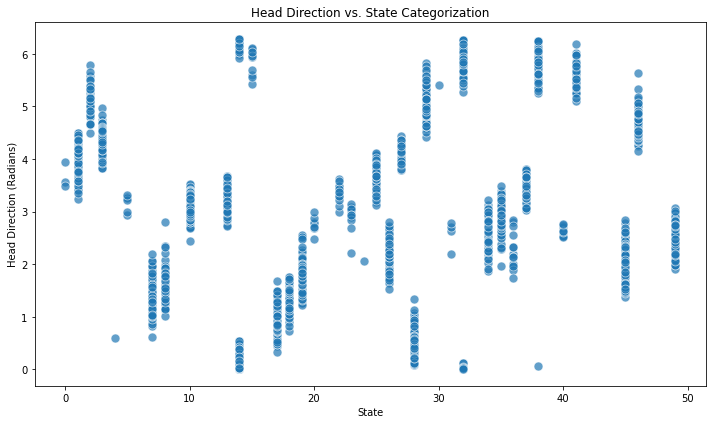

In [19]:
scatterplot_with_color(y, states_head)

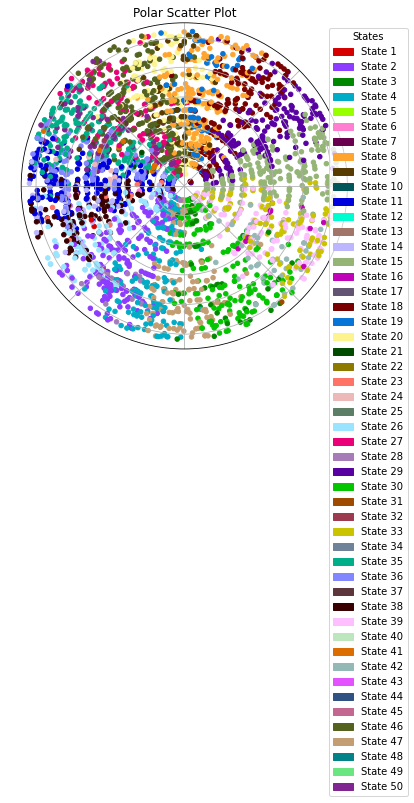

In [20]:
plot_polar_scatter(y, states_head)